## TSA handbook 8 - Winningest Methods in Time Series Forecasting

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2022.09.05 </div> 
<div style="text-align: right"> Last update: 2022.09.05</div> 

- https://phdinds-aim.github.io/time_series_handbook/08_WinningestMethods/lightgbm_m5_forecasting.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import datetime
import missingno as msno
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 30

In [2]:
colors = ["#00798c", "#d1495b", '#edae49', '#66a182', '#4a4a4a',
          '#1a508b', '#e3120b', '#c5a880', '#9F5F80', '#6F9EAF',
          '#0278ae','#F39233', '#A7C5EB', '#54E346', '#ABCE74',
        '#d6b0b1', '#58391c', '#cdd0cb', '#ffb396', '#6930c3']
sns.color_palette(colors[:10])

[(0.0, 0.4745098039215686, 0.5490196078431373),
 (0.8196078431372549, 0.28627450980392155, 0.3568627450980392),
 (0.9294117647058824, 0.6823529411764706, 0.28627450980392155),
 (0.4, 0.6313725490196078, 0.5098039215686274),
 (0.2901960784313726, 0.2901960784313726, 0.2901960784313726),
 (0.10196078431372549, 0.3137254901960784, 0.5450980392156862),
 (0.8901960784313725, 0.07058823529411765, 0.043137254901960784),
 (0.7725490196078432, 0.6588235294117647, 0.5019607843137255),
 (0.6235294117647059, 0.37254901960784315, 0.5019607843137255),
 (0.43529411764705883, 0.6196078431372549, 0.6862745098039216)]

### 1. M5 Dataset

In [3]:
plot_x_size = 15
plot_y_size = 2

np.set_printoptions(precision = 6, suppress = True)

date_list = [d.strftime('%Y-%m-%d') for d in pd.date_range(start = '2011-01-29', end = '2016-04-24')]

In [5]:
df_calendar = pd.read_csv('data/m5-forecasting-accuracy/calendar.csv')
df_price = pd.read_csv('data/m5-forecasting-accuracy/sell_prices.csv')
df_sales = pd.read_csv('data/m5-forecasting-accuracy/sales_train_validation.csv')

In [6]:
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1899,d_1900,d_1901,d_1902,d_1903,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,...,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,...,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,...,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,...,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


In [7]:
df_sales.rename(columns = dict(zip(df_sales.columns[6:], date_list)), inplace = True)
df_sales

,id,item_id,dept_id,cat_id,store_id,state_id,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,...,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,2,0,0,0,1,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,0,0,0,1,2,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,4,2,0,3,0,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,0,0,0,0,...,1,2,0,1,1,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,0,3,1,4,1,...,0,2,0,0,0,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,5,0,1,1,...,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,2,4,1,8,5,...,2,4,0,0,0,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,0,0,0,0,0,...,2,0,1,0,3,0,0,1,0,0,1,0,3,1,3


In [8]:
df_calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [9]:
df_price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


#### Sample Product

세일즈 품목 하나를 꺼내보자.

In [10]:
df_sample = df_sales.iloc[3, :] # 3번째 품목

In [12]:
df_sample.head(10)

id            HOBBIES_1_004_CA_1_validation
item_id                       HOBBIES_1_004
dept_id                           HOBBIES_1
cat_id                              HOBBIES
store_id                               CA_1
state_id                                 CA
2011-01-29                                0
2011-01-30                                0
2011-01-31                                0
2011-02-01                                0
Name: 3, dtype: object

날짜별 세일즈만 추려보자.

In [13]:
series_sample = df_sample.iloc[6:]

In [14]:
series_sample

2011-01-29    0
2011-01-30    0
2011-01-31    0
2011-02-01    0
2011-02-02    0
             ..
2016-04-20    0
2016-04-21    1
2016-04-22    3
2016-04-23    7
2016-04-24    2
Name: 3, Length: 1913, dtype: object

<AxesSubplot:>

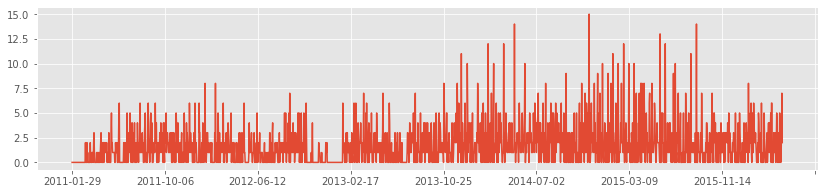

In [16]:
series_sample.plot(figsize = (14, 3))

#### Pick a Time series

상점별 매출 합계 데이터셋을 만든다.

In [17]:
df_sales_total_by_store = df_sales.groupby(['store_id']).sum()

In [18]:
df_sales_total_by_store

,2011-01-29,2011-01-30,2011-01-31,2011-02-01,2011-02-02,2011-02-03,2011-02-04,2011-02-05,2011-02-06,2011-02-07,2011-02-08,2011-02-09,2011-02-10,2011-02-11,2011-02-12,...,2016-04-10,2016-04-11,2016-04-12,2016-04-13,2016-04-14,2016-04-15,2016-04-16,2016-04-17,2016-04-18,2016-04-19,2016-04-20,2016-04-21,2016-04-22,2016-04-23,2016-04-24
store_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,2995,2710,2928,3078,4316,...,5969,4484,3579,3478,3637,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,2123,1901,2436,2584,3455,...,6297,3891,3798,3545,3441,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,4447,4544,4406,4380,5187,...,8602,6580,5641,5377,5493,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,1368,1195,1434,1312,1652,...,3195,2535,2174,2214,2498,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,1607,2149,1895,2256,2944,...,4148,3168,3029,2852,2924,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,2628,2669,2515,2883,4000,...,5035,4033,3484,3348,3851,3897,4475,4998,3311,3727,3384,3446,3902,4483,4292
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,1989,1922,1699,2063,3137,...,4635,3973,3905,3494,3517,3819,4261,4519,3147,3938,3315,3380,3691,4083,3957
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,1335,1410,1349,1946,2634,...,4995,3493,3388,3169,3241,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,1526,1846,1785,2015,2442,...,6012,6227,5934,4584,5263,6259,5579,5566,4347,4464,4194,4393,4988,5404,5127


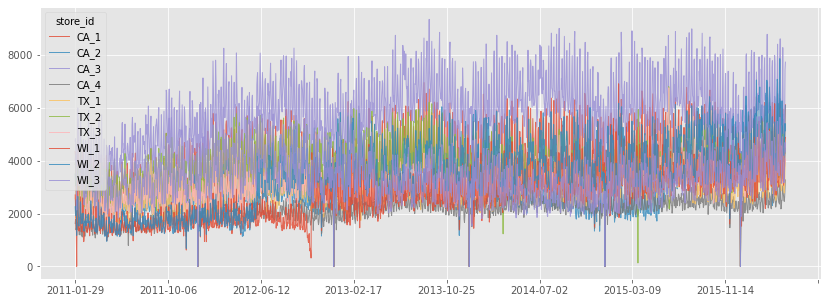

In [20]:
df_sales_total_by_store.T.plot(figsize = (14, 5), linewidth = 1, alpha = 0.8)
plt.show()

1번 상점만 살펴보기

CA_1
Min Dates:['2011-12-25', '2012-12-25', '2013-12-25', '2014-12-25', '2015-12-25']


<AxesSubplot:>

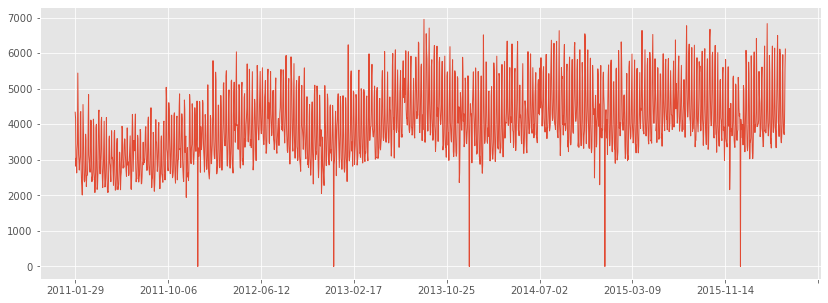

In [23]:
series = df_sales_total_by_store.iloc[0]
print(series.name)
print('Min Dates:' + str(series[series == series.min()].index.to_list()))
series.plot(figsize = (14, 5), linewidth = 1)

### 2. Pre-processing

In [25]:
from statsmodels.tsa.stattools import adfuller

In [26]:
result = adfuller(series)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.035408
p-value: 0.271267
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


#### Does differencing make the series stationary?

In [27]:
def difference(dataset, interval = 1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [28]:
series_d1 = difference(series)
result = adfuller(series_d1)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -20.626012
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


#### Is the series seasonal?

In [29]:
from statsmodels.graphics.tsaplots import plot_acf

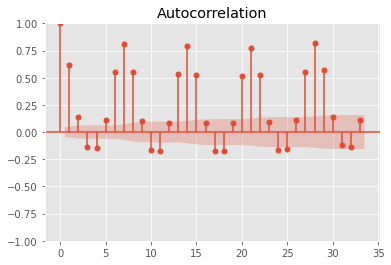

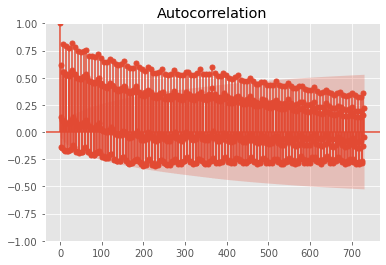

In [30]:
plot_acf(series)
plt.show()

plot_acf(series, lags = 730, use_vlines = True)
plt.show()

#### Can we remove the seasonality?

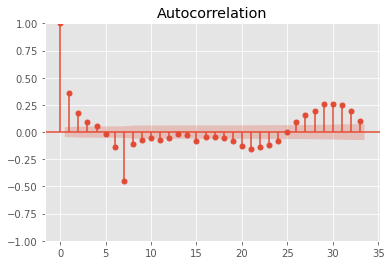

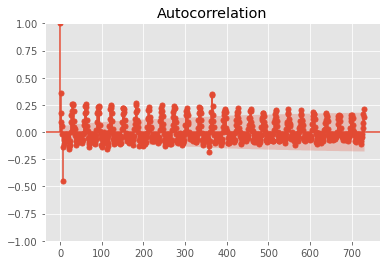

In [31]:
series_d7 = difference(series, 7)

plot_acf(series_d7)
plt.show()

plot_acf(series_d7, lags = 730, use_vlines = True)
plt.show()

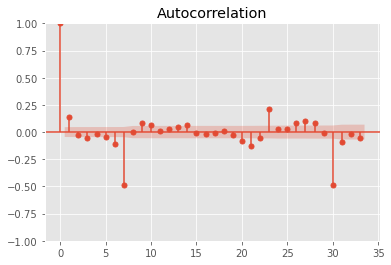

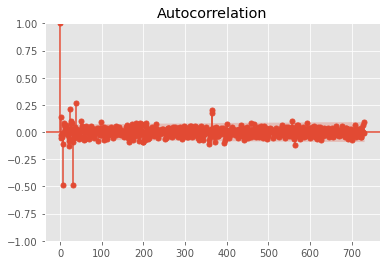

In [32]:
series_d7_d30 = difference(series_d7, 30)

plot_acf(series_d7_d30)
plt.show()

plot_acf(series_d7_d30, lags = 730, use_vlines = True)
plt.show()

In [33]:
result = adfuller(series_d7_d30)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')

for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.405429
p-value: 0.000000
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


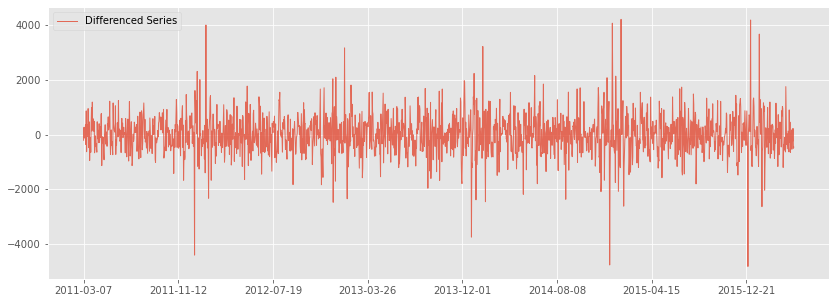

In [35]:
series_d7_d30 = pd.Series(series_d7_d30)
series_d7_d30.index = date_list[37:]

series_d7_d30.plot(label = 'Differenced Series', figsize = (14, 5), linewidth = 1, alpha = 0.8)
plt.legend()
plt.show()

### 3. One-Step Prediction

먼저 데이터를 지도학습용 데이터로 변환한다.  
X: 피처, y: 타겟

#### How far do we lookback? : 얼마나 뒤까지 lag를 참고 할 것인가?

윈도우 사이즈를 하이퍼파라미터로 지정한다.

In [36]:
### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [37]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ### (include shuffling later)
test_size = 28
split_time = len(series) - test_size # 마지막 28일을 시험 데이터로

In [38]:
series

2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
              ... 
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113
Name: CA_1, Length: 1913, dtype: int64

In [39]:
train_series = series[:split_time]
test_series = series[split_time - window_size:]

In [46]:
X_train, y_train = create_xy(train_series, window_size, prediction_horizon)
X_test, y_test = create_xy(test_series, window_size, prediction_horizon)

In [47]:
X_train

array([[4337, 4155, 2816, ..., 2680, 3444, 4241],
       [4155, 2816, 3051, ..., 3444, 4241, 4147],
       [2816, 3051, 2630, ..., 4241, 4147, 2889],
       ...,
       [3387, 4041, 4867, ..., 3776, 3770, 3970],
       [4041, 4867, 5453, ..., 3770, 3970, 4904],
       [4867, 5453, 4256, ..., 3970, 4904, 6139]], dtype=int64)

In [48]:
X_train.shape

(1520, 365)

In [49]:
series.shape

(1913,)

In [50]:
X_test.shape

(28, 365)

In [51]:
y_test

array([[3905],
       [3788],
       [3339],
       [4076],
       [4983],
       [5877],
       [6496],
       [4812],
       [4063],
       [3964],
       [3655],
       [4719],
       [6112],
       [5969],
       [4484],
       [3579],
       [3478],
       [3637],
       [3982],
       [5437],
       [5954],
       [4345],
       [3793],
       [3722],
       [3709],
       [4387],
       [5577],
       [6113]], dtype=int64)

In [52]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [53]:
y_test

array([3905, 3788, 3339, 4076, 4983, 5877, 6496, 4812, 4063, 3964, 3655,
       4719, 6112, 5969, 4484, 3579, 3478, 3637, 3982, 5437, 5954, 4345,
       3793, 3722, 3709, 4387, 5577, 6113], dtype=int64)

<AxesSubplot:>

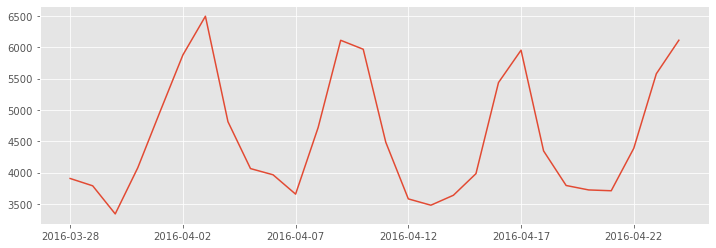

In [55]:
series[-test_size:].plot(figsize = (12, 4))

### LightGBM

In [56]:
import lightgbm as lgb

In [57]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

In [58]:
model.fit(X_train, y_train, eval_metric='l1', eval_set=[(X_test, y_test)], verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

In [59]:
forecast = model.predict(X_test)

In [60]:
s1_naive = series[-29:-1].to_numpy()
s7_naive = series[-35:-7].to_numpy()
s30_naive = series[-56:-28].to_numpy()
s365_naive = series[-364:-336].to_numpy()

In [61]:
print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - y_test))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - y_test))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - y_test))))
print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - y_test))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - y_test))))

     Naive MAE: 698.0000
  s7-Naive MAE: 372.2857
 s30-Naive MAE: 330.8214
s365-Naive MAE: 247.9286
  LightGBM MAE: 200.5037


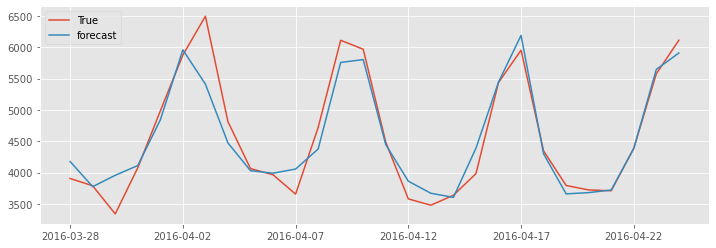

In [62]:
fig, ax = plt.subplots(figsize = (12, 4))
series[-test_size:].plot(label = 'True', ax = ax)
ax.plot(forecast, label= 'forecast')
plt.legend()
plt.show()

#### Tuning window_size

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [64]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

windows = [7, 30, 180, 365, 545, 730]

results = []
names = []

In [65]:
for w in windows:
    window_size = w
    
    X_train, y_train = create_xy(train_series, window_size, prediction_horizon)
    y_train = y_train.flatten()
    
    cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), X_train, y_train,
                            scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

  7 --- MAE: -333.105 (21.291)
 30 --- MAE: -307.008 (21.648)
180 --- MAE: -291.474 (22.537)
365 --- MAE: -275.644 (17.895)
545 --- MAE: -277.332 (20.982)
730 --- MAE: -275.664 (23.006)


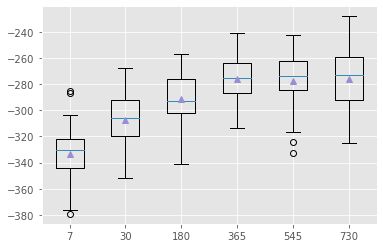

In [66]:
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

### 4. Mult-step prediction

일단 데이터셋을 만들자.

In [68]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ###
test_size = 28
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

X_train, y_train = create_xy(train_series, window_size, prediction_horizon)
X_test, y_test = create_xy(test_series, window_size, prediction_horizon)

y_train = y_train.flatten()
y_test = y_test.flatten()

#### Recursive forecasting

In [69]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(X_train, y_train,
          eval_metric = 'l1', 
          eval_set = [(X_test, y_test)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

In [70]:
X_test

array([[5453, 4256, 3877, ..., 4904, 6139, 4669],
       [4256, 3877, 4446, ..., 6139, 4669, 3905],
       [3877, 4446, 4395, ..., 4669, 3905, 3788],
       ...,
       [3797, 4312, 6019, ..., 3793, 3722, 3709],
       [4312, 6019, 5815, ..., 3722, 3709, 4387],
       [6019, 5815, 3995, ..., 3709, 4387, 5577]], dtype=int64)

In [71]:
recursive_x = X_test[0, :]

In [72]:
recursive_x

array([5453, 4256, 3877, 4446, 4395, 5632, 6636, 4874, 4101, 3810, 3809,
       3726, 4584, 5495, 6093, 4171, 3702, 3668, 3732, 4236, 5651, 5849,
       4131, 3543, 3444, 3797, 4312, 6019, 5815, 3995, 3526, 3560, 3466,
       5121, 5801, 6524, 4794, 4168, 4025, 4182, 4697, 5840, 5014, 4602,
       3810, 3958, 3487, 4375, 5589, 5568, 4185, 3576, 3580, 3635, 4578,
       5415, 5412, 4859, 3609, 3722, 3381, 3803, 5342, 5980, 4702, 4282,
       4007, 3818, 4646, 5710, 5826, 4475, 4145, 4210, 3844, 4605, 5495,
       5844, 4454, 3792, 3902, 4018, 4780, 5506, 4881, 4263, 4259, 3851,
       3862, 4353, 5328, 5776, 3919, 4018, 4550, 4889, 6369, 4434, 5142,
       4915, 4410, 4030, 4220, 5132, 5631, 5919, 4424, 3805, 3971, 4097,
       4598, 5133, 5655, 4389, 3796, 4106, 3843, 4391, 4611, 5254, 4739,
       3951, 3632, 4072, 4865, 5877, 6768, 5326, 4418, 4202, 4332, 4782,
       6020, 6252, 4720, 4147, 4074, 3671, 4419, 5408, 6154, 4760, 3796,
       3868, 3876, 4198, 5122, 6222, 3888, 3364, 35

In [74]:
forecast_ms = []

for i in range(X_test.shape[0]):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)

In [75]:
forecast_ms

[array([3789.15826]),
 array([3955.532616]),
 array([4294.435872]),
 array([5093.274075]),
 array([5941.1541]),
 array([5334.461396]),
 array([4520.953603]),
 array([3964.324996]),
 array([4020.161994]),
 array([4065.415095]),
 array([4519.681792]),
 array([5682.98957]),
 array([5850.194142]),
 array([4458.225407]),
 array([3861.032085]),
 array([3741.700415]),
 array([3722.204424]),
 array([4340.121642]),
 array([5546.186179]),
 array([6180.566488]),
 array([4327.476442]),
 array([3709.467825]),
 array([3681.902423]),
 array([3821.545922]),
 array([4423.898964]),
 array([5696.676953]),
 array([5905.039571]),
 array([4348.114981])]

In [78]:
forecast_ms_rec = np.asarray(forecast_ms).flatten()

In [79]:
forecast_os = model.predict(X_test)

In [80]:
print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast_ms_rec - test_y))))

  One-Step MAE: 997.1229
Multi-Step MAE: 994.7885


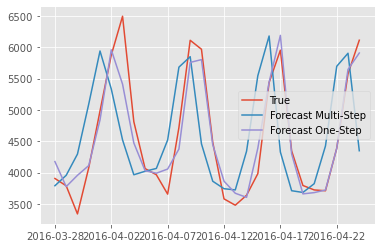

In [81]:
series[-test_size:].plot(label = 'True')
plt.plot(forecast_ms_rec, label = 'Forecast Multi-Step')
plt.plot(forecast_os, label = 'Forecast One-Step')
plt.legend()
plt.show()

#### Direct Forecasting

In [82]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 28

### TRAIN VAL SPLIT ###
test_size = 28
split_time = len(series) - test_size

In [84]:
train_series = series[: split_time]
test_series = series[split_time - window_size:]

X_train, y_train = create_xy(train_series, window_size, prediction_horizon)
X_test, y_test = create_xy(test_series, window_size, prediction_horizon)

In [85]:
X_train

array([[4337, 4155, 2816, ..., 2680, 3444, 4241],
       [4155, 2816, 3051, ..., 3444, 4241, 4147],
       [2816, 3051, 2630, ..., 4241, 4147, 2889],
       ...,
       [4114, 5603, 5774, ..., 3369, 3396, 4087],
       [5603, 5774, 4013, ..., 3396, 4087, 5329],
       [5774, 4013, 3827, ..., 4087, 5329, 6198]], dtype=int64)

In [86]:
y_train

array([[4147, 2889, 2892, ..., 2798, 3280, 4806],
       [2889, 2892, 3205, ..., 3280, 4806, 4430],
       [2892, 3205, 3409, ..., 4806, 4430, 2998],
       ...,
       [5329, 6198, 3797, ..., 3770, 3970, 4904],
       [6198, 3797, 3830, ..., 3970, 4904, 6139],
       [3797, 3830, 3754, ..., 4904, 6139, 4669]], dtype=int64)

In [87]:
from sklearn.multioutput import MultiOutputRegressor

In [88]:
model = MultiOutputRegressor(lgb.LGBMRegressor(), n_jobs=-1)
model.fit(X_train, y_train)

MultiOutputRegressor(estimator=LGBMRegressor(), n_jobs=-1)

In [89]:
forecast_ms_dir = model.predict(X_test)

In [90]:
forecast_ms_dir

array([[4127.848353, 3862.309352, 3925.195649, 4283.773569, 4710.922074,
        5832.730179, 5552.432573, 4425.155976, 3944.022854, 4012.074916,
        4036.197136, 4468.78859 , 5602.179743, 5978.766351, 4297.998599,
        3838.929091, 3908.895549, 3735.400248, 4370.640599, 5491.864561,
        6029.114526, 4193.905425, 3688.796136, 3584.749339, 3739.944415,
        4260.320174, 5722.258068, 5816.497992]])

In [92]:
print('  One-Step MAE: %.4f' % (np.mean(np.abs(forecast_os - test_y))))
print('Multi-Step MAE: %.4f' % (np.mean(np.abs(forecast_ms_dir - test_y))))

  One-Step MAE: 997.1229
Multi-Step MAE: 985.6668


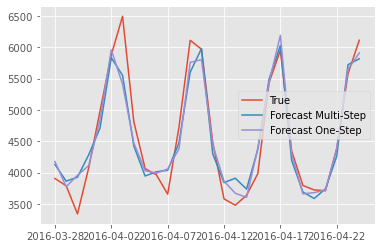

In [93]:
series[-test_size:].plot(label = 'True')
plt.plot(forecast_ms_dir.T, label = 'Forecast Multi-Step')
plt.plot(forecast_os, label = 'Forecast One-Step')
plt.legend()
plt.show()

#### Single-shot forecasting

예측 정확도를 향상시키는 방법은  평균을 취하는 것이다.

In [94]:
forecast_ms_comb = 0.5*forecast_ms_dir.flatten() + 0.5*forecast_ms_rec

print('  Recursive MAE: %.4f' % (np.mean(np.abs(forecast_ms_rec - y_test))))
print('     Direct MAE: %.4f' % (np.mean(np.abs(forecast_ms_dir - y_test))))
print('Combination MAE: %.4f' % (np.mean(np.abs(forecast_ms_comb - y_test))))

  Recursive MAE: 748.4268
     Direct MAE: 233.6326
Combination MAE: 457.1283


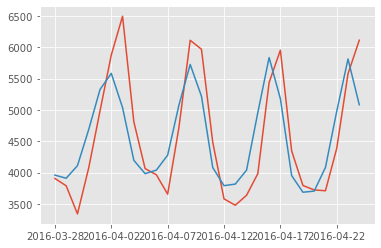

In [95]:
series[-test_size:].plot(label = 'True')
plt.plot(forecast_ms_comb, label = 'Forecast Combination')
plt.show()

### 5. Feature Importance

In [96]:
### HYPERPARAMETERS ###
window_size = 365
prediction_horizon = 1

### TRAIN VAL SPLIT ###
test_size = 28
split_time = len(series) - test_size

train_series = series[:split_time]
test_series = series[split_time - window_size:]

X_train, y_train = create_xy(train_series, window_size, prediction_horizon)
X_test, y_test = create_xy(test_series, window_size, prediction_horizon)

y_train = y_train.flatten()
y_test = y_test.flatten()

In [97]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

In [98]:
feature_name_list = ['lag_' + str(i+1) for i in range(window_size)]

In [99]:
model.fit(X_train, y_train,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          feature_name = feature_name_list,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, max_depth=4,
              n_estimators=2000, num_leaves=16)

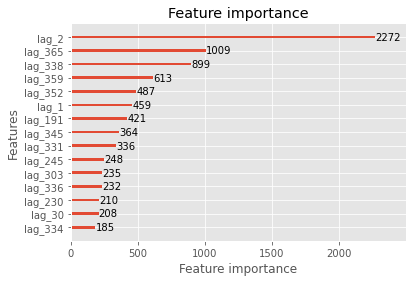

In [100]:
lgb.plot_importance(model, max_num_features = 15, importance_type = 'split')
plt.show()